Jumlah Data Latih CF: 198
Jumlah Data Uji CF: 50
Jumlah Data Latih CBF: 198
Jumlah Data Uji CBF: 50
Hit Rate CF Before Testing: 0.00
Hit Rate CBF Before Testing: 0.21
Hit Rate Hybrid Before Testing: 1.00
Hit Rate CF After Testing: 0.00
Hit Rate CBF After Testing: 0.16
Hit Rate Hybrid After Testing: 1.00


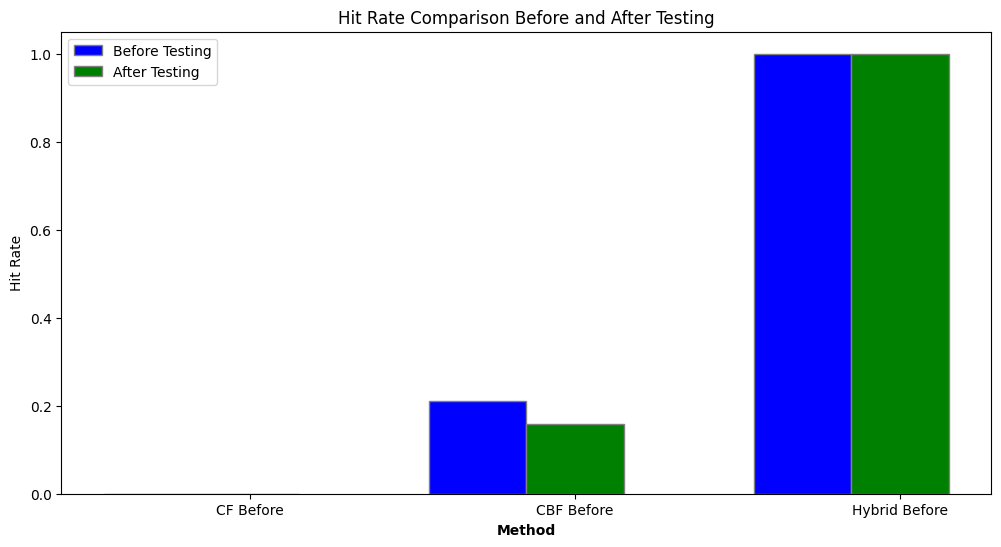

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Load data CF dan CBF
cf = pd.read_csv('cf.csv')
cbf = pd.read_csv('cbf.csv')

# Split data CF
x = cf[['user_id', 'course_id', 'rating']]
y = cf[['course_id']]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=36)

print("Jumlah Data Latih CF:", len(x_train))
print("Jumlah Data Uji CF:", len(x_test))

# Split data CBF
q = cbf[['user_id', 'course_id', 'rating', 'description']]
l = cbf[['course_id']]
q_train, q_test, l_train, l_test = train_test_split(q, l, test_size=0.2, random_state=36)

print("Jumlah Data Latih CBF:", len(q_train))
print("Jumlah Data Uji CBF:", len(q_test))

# Fungsi untuk rekomendasi CBF
def recommend_CBF(user_id, top_n=5):
    user_courses = q_train[q_train['user_id'] == user_id]['course_id']
    unseen_courses = q_train[~q_train['course_id'].isin(user_courses)]
    if unseen_courses.empty:
        return []
    tfidf_vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_matrix_cbf = tfidf_vectorizer.fit_transform(unseen_courses['description'])
    cosine_sim_cbf = cosine_similarity(tfidf_matrix_cbf, tfidf_matrix_cbf)
    course_scores = cosine_sim_cbf.mean(axis=0)
    recommended_courses_indices = np.argsort(course_scores)[::-1][:top_n]
    recommended_courses = q_train.iloc[recommended_courses_indices]
    return recommended_courses['course_id'].tolist()

# Fungsi untuk rekomendasi CF
def recommend_CF(user_id, top_n=5):
    if user_id not in x_train['user_id'].unique():
        return []
    cf_unique = x_train.groupby(['user_id', 'course_id']).rating.mean().reset_index()
    user_ratings = cf_unique.pivot(index='user_id', columns='course_id', values='rating').fillna(0)
    user_similarity = cosine_similarity(user_ratings)
    user_index = user_ratings.index.get_loc(user_id)
    similarity_scores = user_similarity[user_index]
    similar_users = np.argsort(similarity_scores)[::-1]
    
    recommendations = {}
    
    for similar_user in similar_users:
        if similar_user != user_index:
            similar_user_id = user_ratings.index[similar_user]
            similar_user_ratings = x_train[x_train['user_id'] == similar_user_id]
            for _, row in similar_user_ratings.iterrows():
                if row['course_id'] not in user_ratings.columns or user_ratings.loc[user_id, row['course_id']] == 0:
                    if row['course_id'] not in recommendations:
                        recommendations[row['course_id']] = row['rating'] * similarity_scores[similar_user]
                    else:
                        recommendations[row['course_id']] += row['rating'] * similarity_scores[similar_user]
    
    recommended_courses = sorted(recommendations.items(), key=lambda x: x[1], reverse=True)[:top_n]
    return [course_id for course_id, _ in recommended_courses]

# Fungsi untuk rekomendasi hybrid
def recommend_hybrid(user_id, top_n=100):
    cbf_recommendations = recommend_CBF(user_id, top_n * 2)
    cf_recommendations = recommend_CF(user_id, top_n * 2)
    combined_recommendations = list(set(cbf_recommendations + cf_recommendations))
    if len(combined_recommendations) > top_n:
        combined_recommendations = combined_recommendations[:top_n]
    return combined_recommendations

# Fungsi untuk menghitung hit rate
def calculate_hit_rate(interactions, recommendations):
    hits = 0
    total_users = len(recommendations)
    
    for user, recommended_items in recommendations.items():
        if user in interactions and interactions[user]:
            if any(item in interactions[user] for item in recommended_items):
                hits += 1
                
    hit_rate = hits / total_users
    return hit_rate

# Data interaksi pengguna untuk pengujian
user_item_interactions = x_test.groupby('user_id')['course_id'].apply(list).to_dict()

# Rekomendasi sebelum pengujian
recommendations_cf_before = {user: recommend_CF(user) for user in user_item_interactions}
recommendations_cbf_before = {user: recommend_CBF(user) for user in user_item_interactions}
recommendations_hybrid_before = {user: recommend_hybrid(user) for user in user_item_interactions}

# Hit rate sebelum pengujian
hit_rate_cf_before = calculate_hit_rate(user_item_interactions, recommendations_cf_before)
hit_rate_cbf_before = calculate_hit_rate(user_item_interactions, recommendations_cbf_before)
hit_rate_hybrid_before = calculate_hit_rate(user_item_interactions, recommendations_hybrid_before)

print(f"Hit Rate CF Before Testing: {hit_rate_cf_before:.2f}")
print(f"Hit Rate CBF Before Testing: {hit_rate_cbf_before:.2f}")
print(f"Hit Rate Hybrid Before Testing: {hit_rate_hybrid_before:.2f}")

# Simulasi perubahan data setelah pengujian
x_train_after = pd.concat([x_train, x_test])
q_train_after = pd.concat([q_train, q_test])

# Fungsi untuk rekomendasi setelah pengujian
def recommend_CBF_after(user_id, top_n=5):
    user_courses = q_train_after[q_train_after['user_id'] == user_id]['course_id']
    unseen_courses = q_train_after[~q_train_after['course_id'].isin(user_courses)]
    if unseen_courses.empty:
        return []
    tfidf_vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_matrix_cbf = tfidf_vectorizer.fit_transform(unseen_courses['description'])
    cosine_sim_cbf = cosine_similarity(tfidf_matrix_cbf, tfidf_matrix_cbf)
    course_scores = cosine_sim_cbf.mean(axis=0)
    recommended_courses_indices = np.argsort(course_scores)[::-1][:top_n]
    recommended_courses = q_train_after.iloc[recommended_courses_indices]
    return recommended_courses['course_id'].tolist()

def recommend_CF_after(user_id, top_n=5):
    if user_id not in x_train_after['user_id'].unique():
        return []
    cf_unique = x_train_after.groupby(['user_id', 'course_id']).rating.mean().reset_index()
    user_ratings = cf_unique.pivot(index='user_id', columns='course_id', values='rating').fillna(0)
    user_similarity = cosine_similarity(user_ratings)
    user_index = user_ratings.index.get_loc(user_id)
    similarity_scores = user_similarity[user_index]
    similar_users = np.argsort(similarity_scores)[::-1]
    
    recommendations = {}
    
    for similar_user in similar_users:
        if similar_user != user_index:
            similar_user_id = user_ratings.index[similar_user]
            similar_user_ratings = x_train_after[x_train_after['user_id'] == similar_user_id]
            for _, row in similar_user_ratings.iterrows():
                if row['course_id'] not in user_ratings.columns or user_ratings.loc[user_id, row['course_id']] == 0:
                    if row['course_id'] not in recommendations:
                        recommendations[row['course_id']] = row['rating'] * similarity_scores[similar_user]
                    else:
                        recommendations[row['course_id']] += row['rating'] * similarity_scores[similar_user]
    
    recommended_courses = sorted(recommendations.items(), key=lambda x: x[1], reverse=True)[:top_n]
    return [course_id for course_id, _ in recommended_courses]

def recommend_hybrid_after(user_id, top_n=100):
    cbf_recommendations = recommend_CBF_after(user_id, top_n * 2)
    cf_recommendations = recommend_CF_after(user_id, top_n * 2)
    combined_recommendations = list(set(cbf_recommendations + cf_recommendations))
    if len(combined_recommendations) > top_n:
        combined_recommendations = combined_recommendations[:top_n]
    return combined_recommendations

# Rekomendasi setelah pengujian
recommendations_cf_after = {user: recommend_CF_after(user) for user in user_item_interactions}
recommendations_cbf_after = {user: recommend_CBF_after(user) for user in user_item_interactions}
recommendations_hybrid_after = {user: recommend_hybrid_after(user) for user in user_item_interactions}

# Hit rate setelah pengujian
hit_rate_cf_after = calculate_hit_rate(user_item_interactions, recommendations_cf_after)
hit_rate_cbf_after = calculate_hit_rate(user_item_interactions, recommendations_cbf_after)
hit_rate_hybrid_after = calculate_hit_rate(user_item_interactions, recommendations_hybrid_after)

print(f"Hit Rate CF After Testing: {hit_rate_cf_after:.2f}")
print(f"Hit Rate CBF After Testing: {hit_rate_cbf_after:.2f}")
print(f"Hit Rate Hybrid After Testing: {hit_rate_hybrid_after:.2f}")

methods = ['CF Before', 'CBF Before', 'Hybrid Before', 'CF After', 'CBF After', 'Hybrid After']
hit_rates_before = [hit_rate_cf_before, hit_rate_cbf_before, hit_rate_hybrid_before]
hit_rates_after = [hit_rate_cf_after, hit_rate_cbf_after, hit_rate_hybrid_after]

plt.figure(figsize=(12, 6))
barWidth = 0.3

# Bar plot sebelum pengujian
r1 = np.arange(len(methods[:3]))
plt.bar(r1, hit_rates_before, color='blue', width=barWidth, edgecolor='grey', label='Before Testing')

# Bar plot setelah pengujian
r2 = [x + barWidth for x in r1]
plt.bar(r2, hit_rates_after, color='green', width=barWidth, edgecolor='grey', label='After Testing')

plt.xlabel('Method', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(methods[:3]))], methods[:3])
plt.ylabel('Hit Rate')
plt.title('Hit Rate Comparison Before and After Testing')
plt.legend()
plt.show()